# Imports and Functions

In [1]:
from sunlab.globals import *
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.common.mathlib.lyapunov import *
from sunlab.sunflow import *

In [2]:
from scipy.signal import correlate2d
from matplotlib import colors

In [3]:
def fill_between(Y, X=None, alpha=0.15, skip=2, count=4, color='green'):
    from numpy import argsort, diag, array
    if X is None:
        X = range(Y.shape[0])
    if isinstance(Y, list):
        Y = array(Y)
    assert len(Y.shape) == 2
    assert count*(1+skip) < Y.shape[1]//2
    S = argsort(Y, axis=1)
    S_min = S[:,0]
    S_max = S[:,-1]
    Y_nmin = lambda n: diag(Y[:,S[:,n]])
    Y_nmax = lambda n: diag(Y[:,S[:,S.shape[1]-n-1]])
    for i in range(count):
        index = i * (1 + skip)
        plt.gca().fill_between(X, Y_nmin(index), Y_nmax(index), alpha=alpha, color=color)

In [4]:
def find_longest_trajectory(trajectories):
    """# Find longest trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import argmin, argmax, isnan
    N = trajectories.shape[2]
    Longest = 0
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        if Longest < X.shape[0]:
            Longest = X.shape[0]
    return Longest

In [5]:
def autocorrelate_trajectory(trajectories, middle_only=True):
    """# Autocorrelate Trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import zeros, bool_, argmin, argmax, isnan
    from numpy.ma import masked_where
    N = trajectories.shape[2]
    DimensionSize = 2 * trajectories.shape[0] - 1
    if middle_only:
        DimensionSize = 1
    CorrelationSize = 2 * find_longest_trajectory(trajectories) - 1
    CorrelationMid = trajectories.shape[0] - 1
    Correlation = zeros((CorrelationSize, DimensionSize * N))
    CorrelationMask = zeros((CorrelationSize, DimensionSize * N)).astype(bool_)
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        correlation = correlate2d(X, X)
        if DimensionSize == 1:
            correlation = correlation[:,[CorrelationMid]]
        C_min = CorrelationSize // 2 - correlation.shape[0] // 2
        C_max = C_min + correlation.shape[0]
        Correlation[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = correlation
        CorrelationMask[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = True
    return Correlation, CorrelationMask, masked_where(~CorrelationMask, Correlation)

In [6]:
def plot_autocorrelation(correlation, resolution=1):
    correlation = correlation[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [7]:
def plot_trajectory_autocorrelation(trajectories, resolution=1):
    correlation = autocorrelate_trajectory(trajectories)[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [8]:
def shrink(data):
    """# Remove Nans
    data: [D,N_t,N]"""
    from numpy import argmin, argmax, isnan
    X = data[:,:,0].T # N_t x Dim
    X_max = min(data.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
    X_min = max(argmin(isnan(X), axis=0))
    X = X[X_min:X_max,:]
    return X

In [236]:
def Persistence_t(trajectory, normalize=False, mask_zero=False):
    """# Persistence
    trajectory: [N_t, Dim]"""
    from numpy.linalg import norm
    from numpy import dot, diag, newaxis
    from numpy.ma import masked_where
    A = trajectory[0:-2,:]
    B = trajectory[1:-1,:]
    C = trajectory[2:, :]
    BA = B - A
    CB = C - B
    if normalize:
        BA_mask = ~masked_where(BA == 0, BA).mask.any(axis=-1)
        CB_mask = ~masked_where(CB == 0, CB).mask.any(axis=-1)
        _mask = BA_mask & CB_mask
        if mask_zero:
            if isinstance(_mask, np.bool_):
                BA = BA
                CB = CB
            else:
                BA = BA[_mask,...]
                CB = CB[_mask,...]
        BA = (BA.T / norm(BA, axis=-1)).T
        CB = (CB.T / norm(CB, axis=-1)).T
        ret = diag(dot(BA, CB.T)).copy()
        if not mask_zero:
            ret[~_mask,...] = 0
            _mask = np.ones_like(_mask).astype(np.bool_)
        return ret, _mask
    return diag(dot(BA, CB.T))

In [147]:
def Motility_t(trajectory, normalize=False):
    """# Motility
    trajectory: [N_t, 2]

    Assumes the center is at the origin"""
    from numpy.linalg import norm
    from numpy import array, diag, sum
    assert len(trajectory.shape) == 2
    assert trajectory.shape[1] == 2
    A = trajectory[:-1,:]
    B = trajectory[1:,:]
    BA = B - A
    if normalize:
        BA /= norm(BA, axis=-1)
    R = A.copy() # Radial direction for the trajectory
    R = (R.T / np.linalg.norm(R, axis=-1)).T # [N_t,2]
    T = array([R[:,1],-R[:,0]]).T # Tangential direction [N_t,2]
    total_motility = BA.copy() # [N_t, 2]
    radial_motility = (diag(total_motility @ R.T) * R.T).T  # [N_t,2]
    tangential_motility = (diag(total_motility @ T.T) * T.T).T  # [N_t,2]
    return total_motility,radial_motility,tangential_motility

# Runtime Parameters

In [12]:
SAVE_EXTRAS = False

In [13]:
g_Base = lambda *args: f"{DIR_ROOT}/Figures/Invasion/ManuallyTracked/"
g_MAX_LAG = 16
g_N_GaussSmooth = 500#250
g_BoxExtra = 2e-2
g_GaussWidth = 0.1

# Setup

In [14]:
model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

#training_dataset = import_10x(FILES['TRAINING_DATASET'], scaler=model.scaler)
reduced_dataset = import_10x(FILES['TRAINING_DATASET_WIDE_BERTH'], scaler=model.scaler)

In [15]:
sampled_manually_tracked_trajectories = np.load_dat(FILES['FIGURES']['3']['TRAJECTORIES'])['trajectories']

In [16]:
stacked_sampled_manually_tracked_trajectories = []
max_size = np.inf
for row in sampled_manually_tracked_trajectories:
    if row.shape[0] < max_size:
        max_size = row.shape[0]
for row in sampled_manually_tracked_trajectories:
    stacked_sampled_manually_tracked_trajectories.append(row[::-1,:][:max_size,:])
stacked_sampled_manually_tracked_trajectories = np.array(stacked_sampled_manually_tracked_trajectories)
_temp = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,:13]
stacked_sampled_manually_tracked_trajectories_MFV = model.scaler(_temp.reshape((-1,13))).reshape(_temp.shape)
stacked_sampled_manually_tracked_trajectories_MLV = model.encoder(stacked_sampled_manually_tracked_trajectories_MFV).numpy()
stacked_sampled_manually_tracked_trajectories_TISSUE = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13:13+2]
stacked_sampled_manually_tracked_trajectories_OTHER = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13+2:]
stacked_sampled_manually_tracked_trajectories_MFV.shape,stacked_sampled_manually_tracked_trajectories_MLV.shape

((16, 20, 13), (16, 20, 2))

In [17]:
total_dataset = np.hstack([stacked_sampled_manually_tracked_trajectories.reshape((-1,17)), stacked_sampled_manually_tracked_trajectories_MLV.reshape((-1,2))])

In [18]:
df_sample = pd.DataFrame(total_dataset, columns=reduced_dataset.data_columns + ["X", "Y", "CellN", "Frame", "MLA-0", "MLA-1"])
df_sample.head()

Area  MjrAxisLength  MnrAxisLength  Eccentricity  ConvexArea  \
0  157.0      23.111674      10.485540      0.891159       199.0   
1  169.0      27.180364      11.440247      0.907107       253.0   
2  166.0      32.142691       9.876421      0.951623       255.0   
3  178.0      24.591893      11.348810      0.887148       243.0   
4  112.0      13.946479      10.767801      0.635525       121.0   

   EquivDiameter  Solidity    Extent  Perimeter  ConvexPerim     FibLen  \
0      14.138550  0.788945  0.594697     56.940       52.598  22.899494   
1      14.668929  0.667984  0.391204     69.023       63.226  29.485279   
2      14.538149  0.650980  0.354701     79.121       76.466  36.899498   
3      15.054456  0.732510  0.436275     64.218       58.578  26.313707   
4      11.941643  0.925620  0.662722     37.836       37.555  15.242641   

   InscribeR    BlebLen      X      Y  CellN  Frame     MLA-0     MLA-1  
0   4.242640   9.242640  341.0  592.0   10.0   49.0 -0.671156 -1.383089  
1   4.123106  17.242641  338.0  591.0   10.0   50.0 -0.943926 -0.594500  
2   4.242640  26.071066  343.0  590.0   10.0   51.0 -1.184902 -0.265609  
3   3.605551  15.242641  338.0  590.0   10.0   52.0 -0.821504 -0.869285  
4   4.000000   3.414214  338.0  587.0   10.0   53.0  0.420395 -2.215417

In [19]:
MFV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MFV.transpose(2,1,0))
MLV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MLV.transpose(2,1,0))
TISSUE_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_OTHER.transpose(2,1,0))

In [20]:
MAX_LAG = g_MAX_LAG

In [21]:
MFV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = model.scaler(row[::-1,:13])
    MFV_msds.append(mmsds(row, MAX_LAG-1))
MFV_msds = np.array(MFV_msds)
MFV_msds.shape

(16, 16)

In [22]:
MLV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = model.encoder(model.scaler(row[::-1,:13])).numpy()
    MLV_msds.append(mmsds(row, MAX_LAG-1))
MLV_msds = np.array(MLV_msds)
MLV_msds.shape

(16, 16)

In [23]:
f_MSD = lambda x, a, b: a * x ** b

In [24]:
MFV_parameters = []
for idx in range(MFV_msds.shape[0]):
    X = range(MFV_msds.shape[1])
    Y = MFV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_msd = np.array(MFV_parameters)

/tmp/4164832.2.sun-gpu.q/ipykernel_23124/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [25]:
MFV_parameters_msd[:,1].mean(),MFV_parameters_msd[:,1].std()

(0.2011281022931541, 0.14606623463379698)

In [26]:
MLV_parameters = []
for idx in range(MLV_msds.shape[0]):
    X = range(MLV_msds.shape[1])
    Y = MLV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_msd = np.array(MLV_parameters)

/tmp/4164832.2.sun-gpu.q/ipykernel_23124/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [27]:
MLV_parameters_msd[:,1].mean(),MLV_parameters_msd[:,1].std()

(0.22499251638901996, 0.1747049080604931)

In [28]:
MFV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lyps.shape, MLV_lyps.shape

((120, 19), (120, 19))

In [29]:
MFV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lrss.shape, MLV_lrss.shape

((120, 19), (120, 19))

In [30]:
f_RS = lambda x, a, b: b * x + a

In [31]:
MFV_parameters = []
for idx in range(MFV_lrss.shape[0]):
    X = range(MFV_lrss.shape[1])
    Y = MFV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_rd = np.array(MFV_parameters)

In [32]:
MFV_parameters_rd[:,1].mean(),MFV_parameters_rd[:,1].std()

(-0.002202363228244758, 0.035655529651686786)

In [33]:
MLV_parameters = []
for idx in range(MLV_lrss.shape[0]):
    f = lambda x, a, b: b * x + a
    X = range(MLV_lrss.shape[1])
    Y = MLV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_rd = np.array(MLV_parameters)

In [34]:
MLV_parameters_rd[:,1].mean(),MLV_parameters_rd[:,1].std()

(-0.0038693046673559514, 0.04275097944778962)

In [238]:
NormalizedPersistenceData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2] - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    TISSUE_persistence, TISSUE_mask = Persistence_t(TISSUE_trajectory, normalize=True, mask_zero=False)
    TISSUE_persistence = TISSUE_persistence[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-2,:][TISSUE_mask,...]
    NormalizedPersistenceVector = np.hstack([ANCHOR_morphology, TISSUE_persistence])
    NormalizedPersistenceData.append(NormalizedPersistenceVector)
NormalizedPersistenceData = np.vstack(NormalizedPersistenceData)
NormalizedPersistenceData.shape

/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:23: RuntimeWarning: invalid value encountered in true_divide
  BA = (BA.T / norm(BA, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:24: RuntimeWarning: invalid value encountered in true_divide
  CB = (CB.T / norm(CB, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:23: RuntimeWarning: invalid value encountered in true_divide
  BA = (BA.T / norm(BA, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:24: RuntimeWarning: invalid value encountered in true_divide
  CB = (CB.T / norm(CB, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:23: RuntimeWarning: invalid value encountered in true_divide
  BA = (BA.T / norm(BA, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:24: RuntimeWarning: invalid value encountered in true_divide
  CB = (CB.T / norm(CB, axis=-1)).T
/tmp/4164832.2.sun-gpu.q/ipykernel_23124/18178279.py:23: RuntimeWarning: invalid value encountered i

(399, 3)

In [155]:
plt.apply_boundary()
LatentExtent = [*plt.xlim(), *plt.ylim()]
plt.close()

In [156]:
TISSUE_NORMALIZED_PERSISTENCE_D,XY = gaussian_smooth_plot(NormalizedPersistenceData[:,[0,1,-1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_NORMALIZED_PERSISTENCE_N,XY = gaussian_smooth_plot(NormalizedPersistenceData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_NORMALIZED_PERSISTENCE_MASK = np.ma.masked_where(TISSUE_NORMALIZED_PERSISTENCE_N<0.01, TISSUE_NORMALIZED_PERSISTENCE_D)
TISSUE_NORMALIZED_PERSISTENCE_XY = XY.copy()

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

In [38]:
PersistenceData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2] - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    MFV_persistence = Persistence_t(MFV_trajectory)[:,np.newaxis]
    MLV_persistence = Persistence_t(MLV_trajectory)[:,np.newaxis]
    TISSUE_persistence = Persistence_t(TISSUE_trajectory)[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-2,:]
    PersistenceVector = np.hstack([ANCHOR_morphology, MFV_persistence, MLV_persistence, TISSUE_persistence])
    PersistenceData.append(PersistenceVector)
PersistenceData = np.vstack(PersistenceData)
PersistenceData.shape

(399, 5)

In [39]:
plt.apply_boundary()
LatentExtent = [*plt.xlim(), *plt.ylim()]
plt.close()

In [40]:
TISSUE_PERSISTENCE_D,XY = gaussian_smooth_plot(PersistenceData[:,[0,1,-1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_PERSISTENCE_N,XY = gaussian_smooth_plot(PersistenceData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_PERSISTENCE_MASK = np.ma.masked_where(TISSUE_PERSISTENCE_N<0.01, TISSUE_PERSISTENCE_D)
TISSUE_PERSISTENCE_XY = XY.copy()

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

In [41]:
MotilityData = []
for sampled_trajectory in sampled_manually_tracked_trajectories:
    time_corrected = sampled_trajectory[::-1,:]
    MFV_trajectory = model.scaler(time_corrected[:,:13])
    MLV_trajectory = model.encoder(MFV_trajectory).numpy()
    TISSUE_trajectory = time_corrected[:,13:13+2]
    TISSUE_trajectory = TISSUE_trajectory - [512,512]
    OTHER_trajectory = time_corrected[:,13+2:]
    TISSUE_motility_total, TISSUE_motility_rad, TISSUE_motility_tang = Motility_t(TISSUE_trajectory)
    TISSUE_motility_total = np.linalg.norm(TISSUE_motility_total,axis=-1)[:,np.newaxis]
    TISSUE_motility_rad = np.linalg.norm(TISSUE_motility_rad,axis=-1)[:,np.newaxis]
    TISSUE_motility_tang = np.linalg.norm(TISSUE_motility_tang,axis=-1)[:,np.newaxis]
    ANCHOR_morphology = MLV_trajectory[:-1,:]
    MotilityVector = np.hstack([ANCHOR_morphology, TISSUE_motility_total, TISSUE_motility_rad, TISSUE_motility_tang])
    MotilityData.append(MotilityVector)
MotilityData = np.vstack(MotilityData)
MotilityData.shape

(415, 5)

In [42]:
TISSUE_MOTILITY_TOTAL,XY = gaussian_smooth_plot(MotilityData[:,[0,1,2]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_RAD,XY = gaussian_smooth_plot(MotilityData[:,[0,1,3]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_TANG,XY = gaussian_smooth_plot(MotilityData[:,[0,1,4]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_N,XY = gaussian_smooth_plot(MotilityData[:,[0,1]], sigma=g_GaussWidth, extent=LatentExtent, grid_n=g_N_GaussSmooth)
TISSUE_MOTILITY_MASK = np.ma.masked_where(TISSUE_MOTILITY_N<0.01, TISSUE_MOTILITY_N)
TISSUE_MOTILITY_XY = XY.copy()

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

In [43]:
TISSUE_MOTILITY_MAX = np.max(TISSUE_MOTILITY_TOTAL/TISSUE_MOTILITY_MASK)

In [44]:
_divnorm = lambda l,h,m=0: colors.TwoSlopeNorm(vmin=l, vcenter=m, vmax=h)
_divnorm_x = lambda x,im=-1e-1,iM=1e-1: _divnorm(min([im,np.min(x)]),max([iM,np.max(x)]))

# Plots

### Displacement Scatter

In [45]:
MFV_diff = stacked_sampled_manually_tracked_trajectories_MFV[:,1:,:]-stacked_sampled_manually_tracked_trajectories_MFV[:,:-1,:]
MLV_diff = stacked_sampled_manually_tracked_trajectories_MLV[:,1:,:]-stacked_sampled_manually_tracked_trajectories_MLV[:,:-1,:]
MFV_diff.shape, MLV_diff.shape

((16, 19, 13), (16, 19, 2))

LinregressResult(slope=0.24088214579652328, intercept=0.03494699044486854, rvalue=0.9509091508472624, pvalue=7.082115279137393e-156, stderr=0.004511083938201466, intercept_stderr=0.003474979085586175)

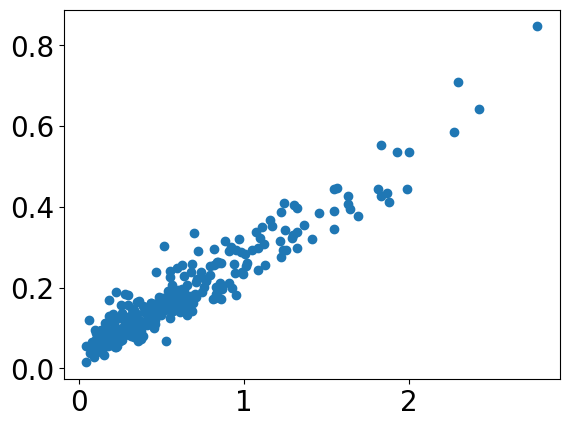

In [46]:
MFV_d = np.linalg.norm(MFV_diff, axis=-1).flatten()
MLV_d = np.linalg.norm(MLV_diff, axis=-1).flatten()
plt.scatter(MLV_d, MFV_d)
linregress(MLV_d, MFV_d)

### MFV-Linear Regression

In [47]:
from scipy.stats import linregress

In [365]:
ALPHA=0.01

In [366]:
_x = np.log((np.array(range(MLV_msds.T.shape[0]))*0.25)[1:])
_t = np.repeat(_x[:,np.newaxis], MLV_msds.shape[1], axis=1).T

In [367]:
res = linregress(_t.flatten(), np.log(MFV_msds[:][:,1:]).flatten())
print(f"{res.slope:5.2f}, p={res.pvalue:.2e}  {res.pvalue<ALPHA}")

 0.19, p=5.36e-16  True


In [368]:
res = linregress(_t.flatten(), np.log(MLV_msds[:][:,1:]).flatten())
print(f"{res.slope:5.2f}, p={res.pvalue:.2e}  {res.pvalue<ALPHA}")

 0.21, p=6.45e-16  True


In [369]:
_x = (np.array(range(MFV_lrss.T.shape[0])))
_t = np.repeat(_x[:,np.newaxis], MFV_lrss.shape[0], axis=1).T

In [370]:
res = linregress(_t.flatten(), (MFV_lyps).flatten())
print(f"{res.slope:5.2f}, p={res.pvalue:.2e}  {res.pvalue<ALPHA}")

 0.00, p=5.77e-04  True


In [371]:
res = linregress(_t.flatten(), (MLV_lyps).flatten())
print(f"{res.slope:5.2f}, p={res.pvalue:.2e}  {res.pvalue<ALPHA}")

 0.00, p=7.65e-02  False


### Trajectory Plots

In [54]:
manual_tracked_shape_dataset = process_and_load_dataset(FILES['PEN_TRACKED']['MANUAL'], FILES['PRETRAINED_MODEL_DIR'], scaler=MaxAbsScaler)
mantrak_dataframe = manual_tracked_shape_dataset.dataframe

In [55]:
_alpha = 0.8

In [56]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_cbar(cmap=mpl.cm.gist_rainbow):
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
    cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    plt.gcf().add_axes(ax_cb)

In [57]:
starting_positions = []
for cell_num in mantrak_dataframe['CellNum'].unique():
    starting_positions.append(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num].tail(1)[['Latent-0','Latent-1']].to_numpy().flatten())
starting_positions = np.array(starting_positions)
starting_positions

array([[-3.2375588 ,  1.366315  ],
       [-0.58467185, -0.8319441 ],
       [-1.6524469 , -0.5375826 ],
       [ 0.71588945, -1.5232104 ],
       [ 0.38881826,  0.17118815],
       [-1.9672638 ,  0.816854  ],
       [ 0.91628265, -1.4529511 ],
       [-0.56676877, -0.99549675],
       [-2.016069  , -0.06995768],
       [-0.67115605, -1.3830892 ],
       [-2.0275002 ,  0.36809167],
       [-0.9270031 ,  0.11044907],
       [-0.41391626, -0.77108675],
       [-0.40960842, -1.6061115 ],
       [-0.54988796, -1.2396952 ],
       [-1.6140852 ,  0.54211754],
       [-3.0611148 ,  1.2426357 ],
       [-1.57183   ,  0.5386945 ],
       [-1.3830386 , -0.5625719 ],
       [-0.80442744, -1.6819787 ],
       [-1.5716635 ,  0.29001233],
       [-0.6945002 , -0.7115761 ],
       [-1.7044144 ,  0.32996747]], dtype=float32)

In [58]:
from sklearn.cluster import KMeans

In [59]:
clusterer = KMeans(4).fit(starting_positions)
np.unique(clusterer.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([ 9, 10,  2,  2]))

In [308]:
mantrak_dataframe['Class'] = np.argmax(mantrak_dataframe[['actinedge','filopodia','bleb','lamellipodia']].to_numpy(), axis=-1)

In [309]:
tclass = mantrak_dataframe['Class'].to_numpy()
tclass[np.max(mantrak_dataframe[['actinedge','filopodia','bleb','lamellipodia']].to_numpy(), axis=-1)>0.7] = 4

In [310]:
mantrak_dataframe['Class-T'] = tclass

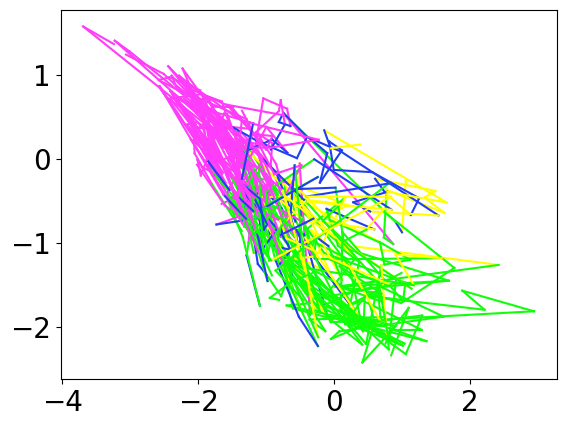

In [313]:
plt.close()
for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
    temp_df = mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]
    min_df = temp_df[['Latent-0','Latent-1','Class']].to_numpy()
    before = min_df[:-1,:]
    after = min_df[1:,:]
    for ridx, row in enumerate(before):
        bx,by,bc = row
        ax,ay = after[ridx,:2]
        plt.plot([bx,ax],[by,ay], c=(Pcolor + ['cyan'])[int(bc)])

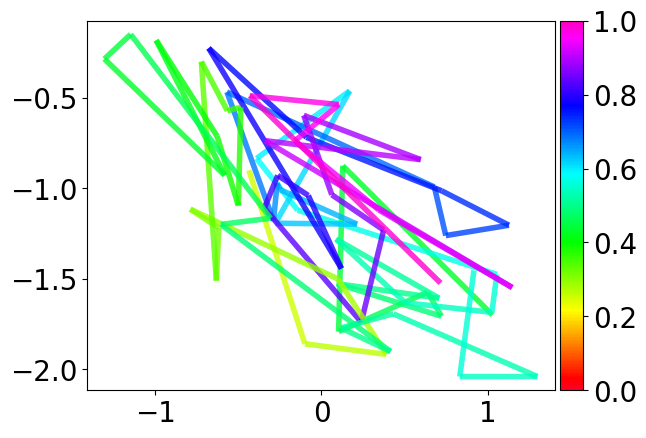

In [60]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Traces_{_LABEL}-Colorbar")

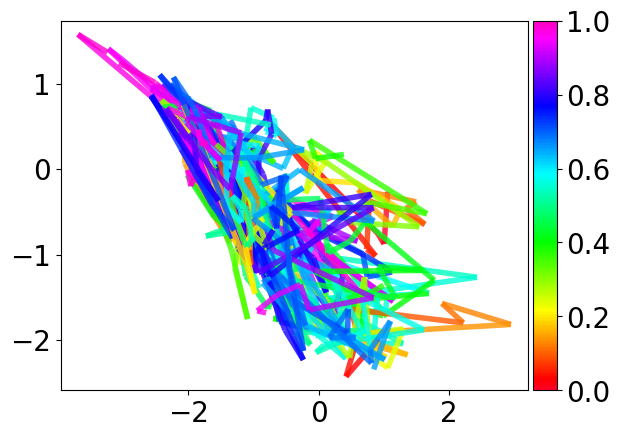

In [61]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
add_cbar()
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces-Colorbar")

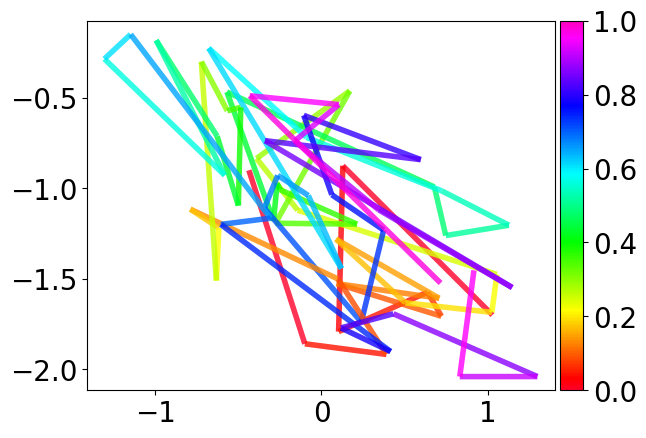

In [62]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Traces-LocalProgression_{_LABEL}-Colorbar")

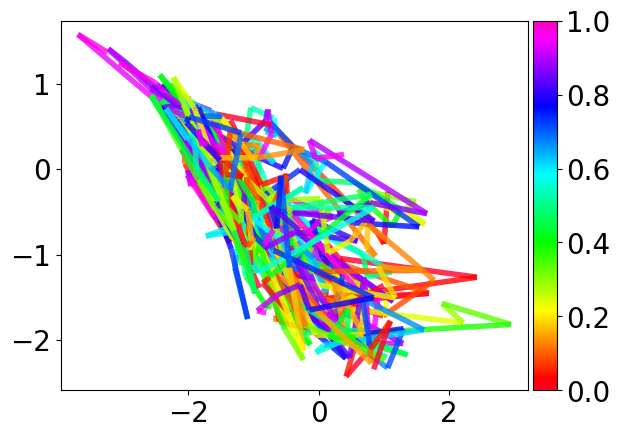

In [63]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
add_cbar()
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces-LocalProgression-Colorbar")

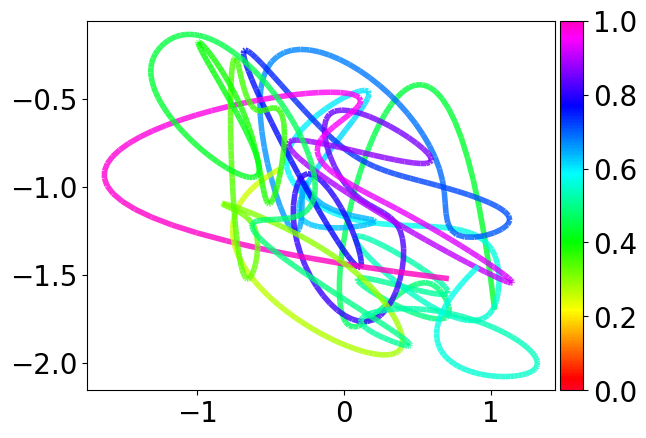

In [64]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Interpolated_{_LABEL}-Colorbar")

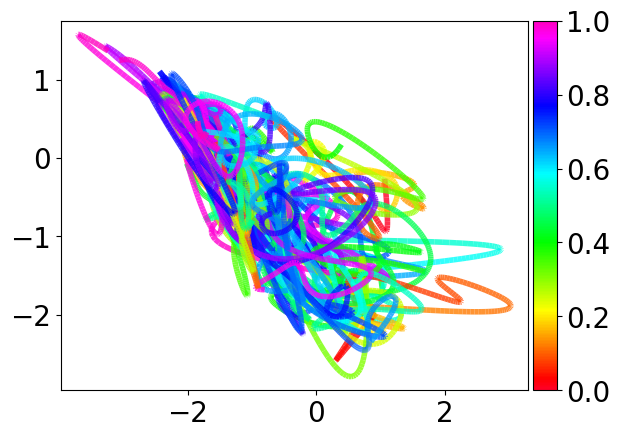

In [65]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
add_cbar()
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated-Colorbar")

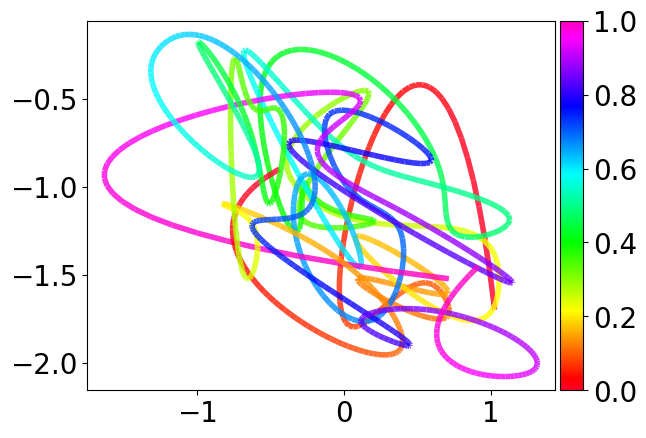

In [66]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Interpolated-LocalProgression_{_LABEL}-Colorbar")

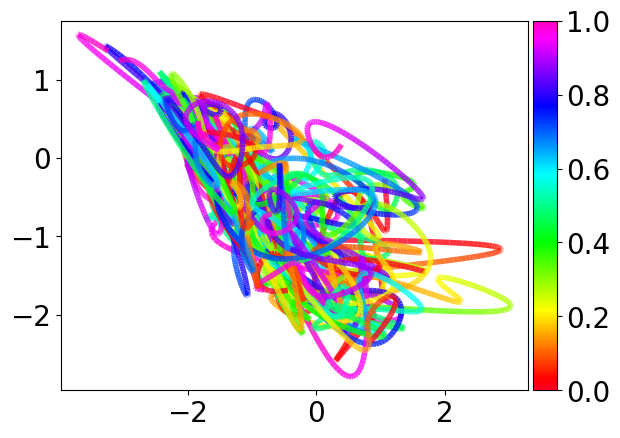

In [67]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
add_cbar()
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated-LocalProgression-Colorbar")

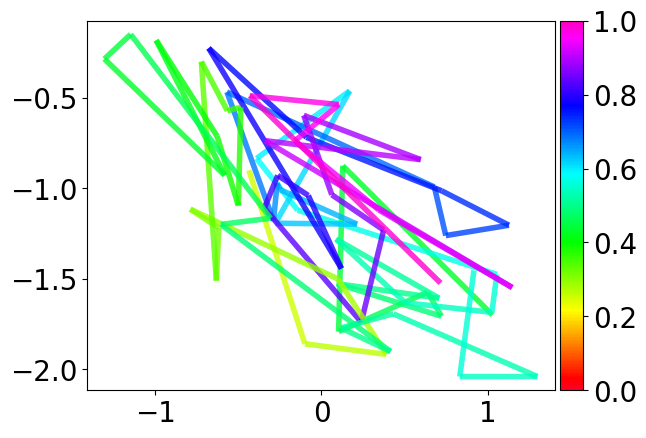

In [68]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Traces_{_LABEL}")

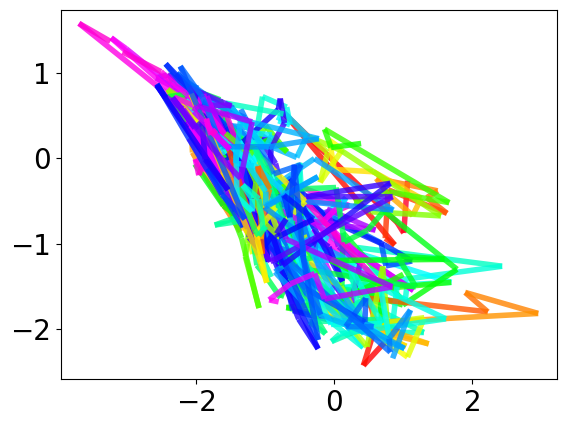

In [69]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces")

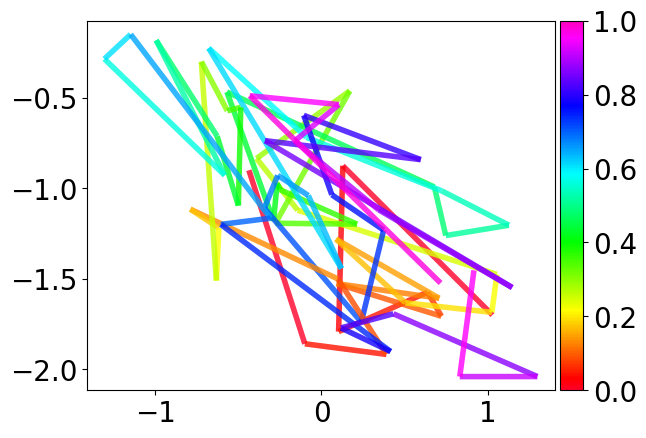

In [70]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Traces-LocalProgression_{_LABEL}")

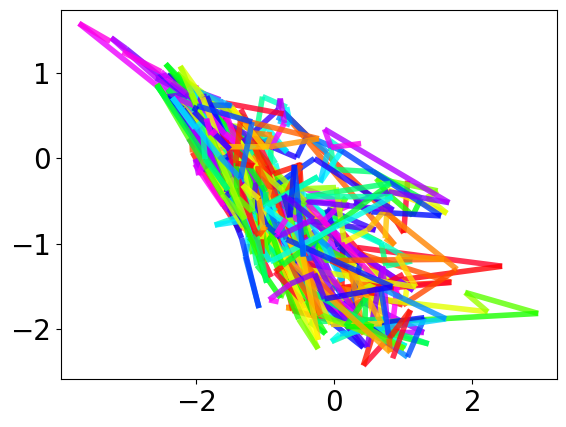

In [71]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=False, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Traces-LocalProgression")

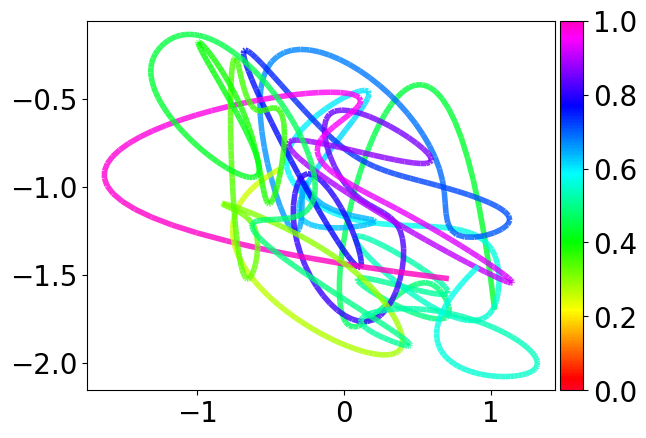

In [72]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Interpolated_{_LABEL}")

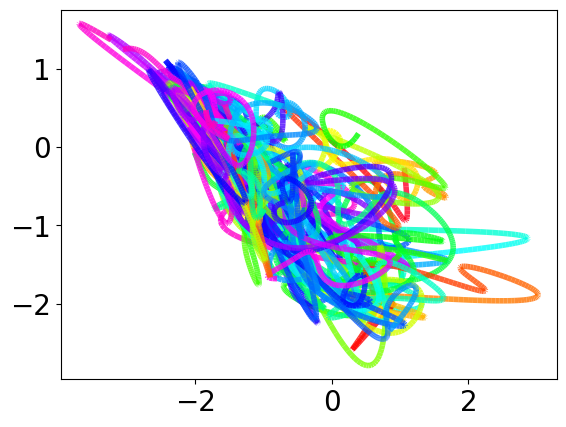

In [73]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated")

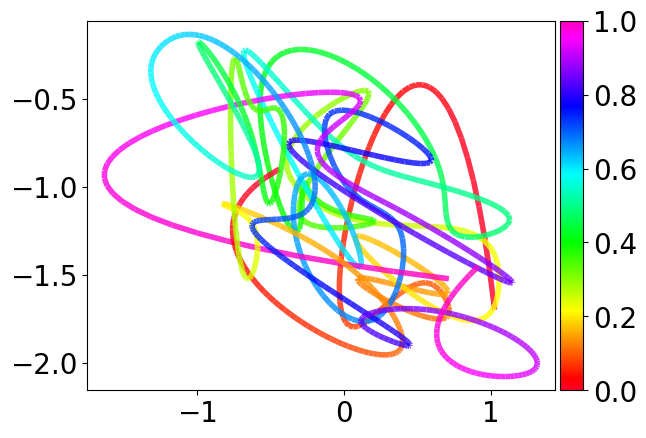

In [74]:
for _LABEL in range(4):
    plt.close()
    for idx,cell_num in enumerate(mantrak_dataframe['CellNum'].unique()):
        if clusterer.labels_[idx] == _LABEL:
            plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
    add_cbar()
    if SAVE_EXTRAS:
        plt.save(g_Base() + f"TrajectoryTraces/Interpolated-LocalProgression_{_LABEL}")

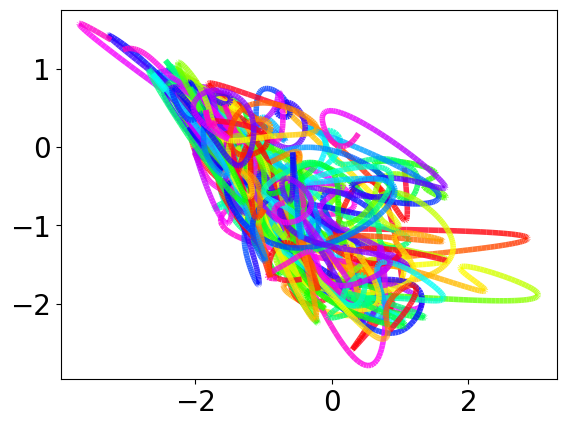

In [75]:
for cell_num in mantrak_dataframe['CellNum'].unique():
    plot_trajectory(mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num], Fm=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].min(), FM=mantrak_dataframe[mantrak_dataframe['CellNum'] == cell_num]['Frames'].max(), interpolate=True, interpolation_N=500, interpolation_kind='cubic', alpha=_alpha, colormap='gist_rainbow')
if SAVE_EXTRAS:
    plt.save(g_Base() + "TrajectoryTraces/Interpolated-LocalProgression")

### Lyapunov

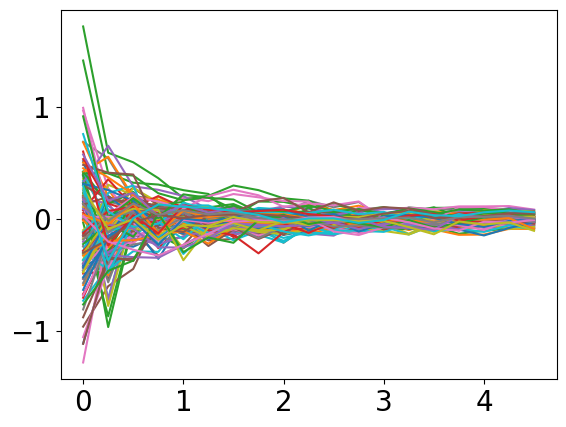

In [76]:
plt.plot(np.array(range(MFV_lyps.T.shape[0]))*0.25, MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV_time")

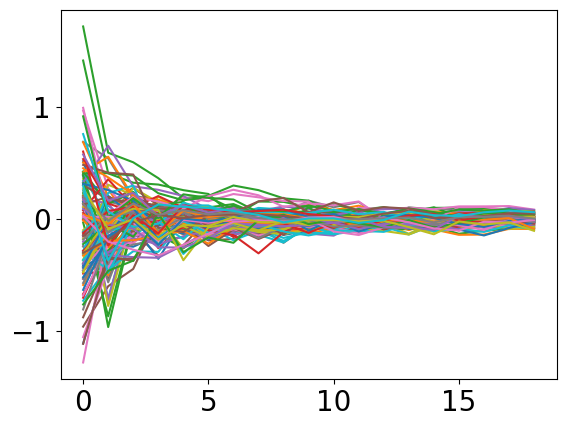

In [77]:
plt.plot(MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV")

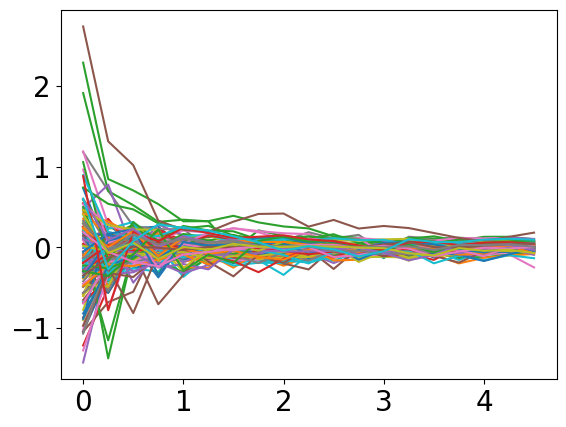

In [78]:
plt.plot(np.array(range(MLV_lyps.T.shape[0]))*0.25, MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV_time")

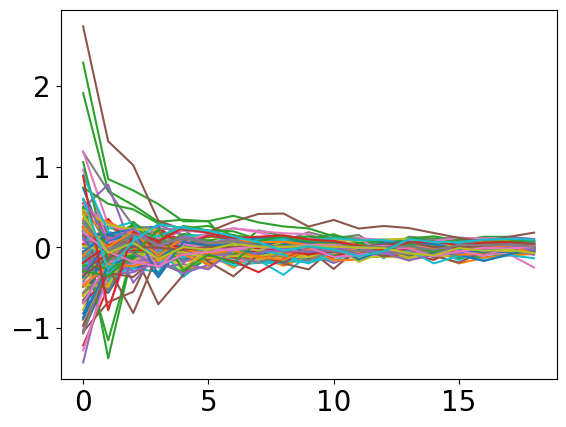

In [79]:
plt.plot(MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV")

### Log Relative Separation

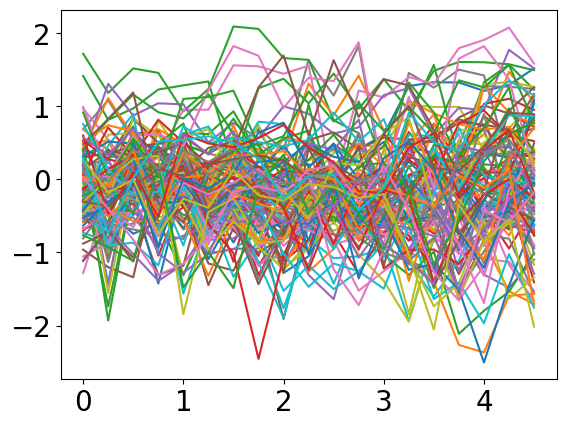

In [80]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_time", _xticks=True, _yticks=True, tighten=False)

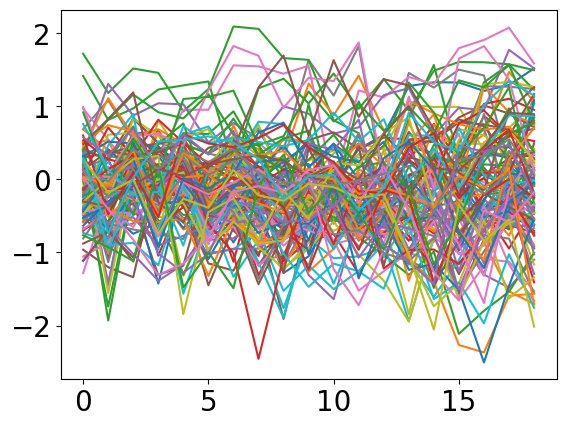

In [81]:
plt.plot(MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV", _xticks=True, _yticks=True, tighten=False)

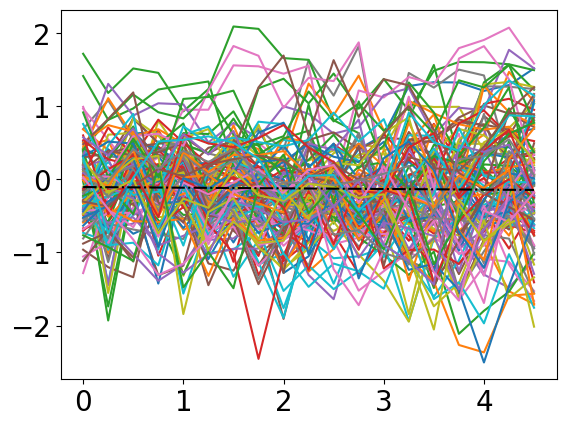

In [82]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

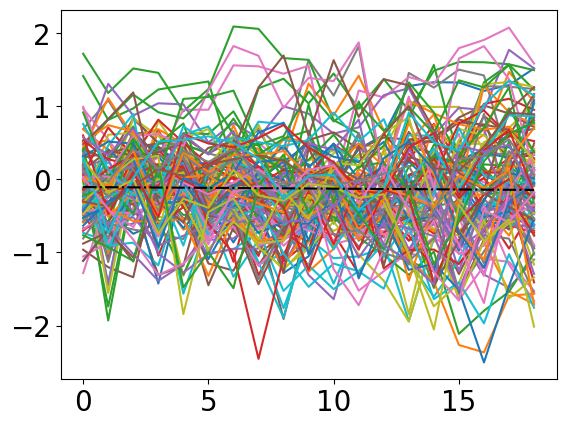

In [83]:
plt.plot(MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

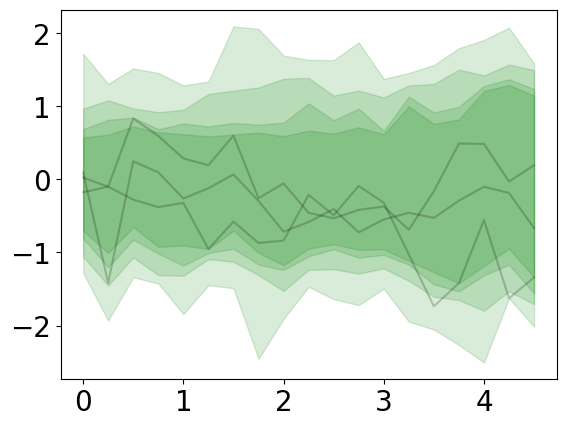

In [84]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_time", _xticks=True, _yticks=True, tighten=False)

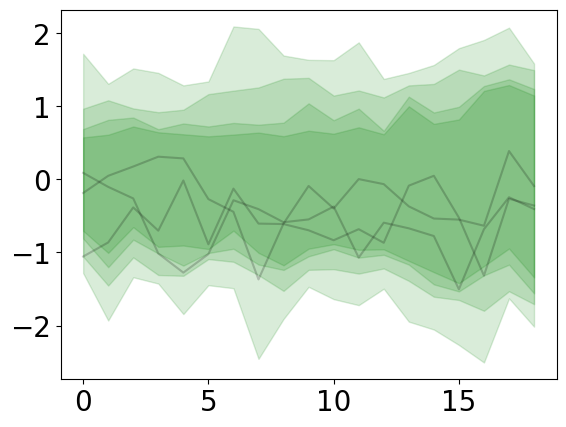

In [85]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density", _xticks=True, _yticks=True, tighten=False)

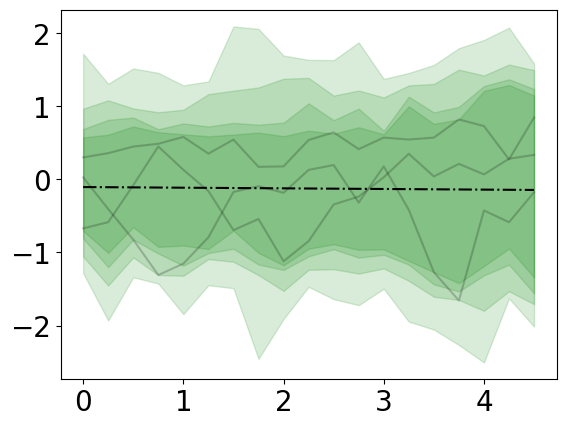

In [86]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

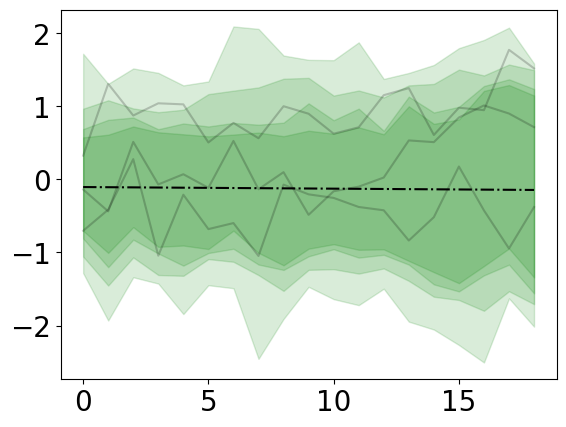

In [87]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed", _xticks=True, _yticks=True, tighten=False)

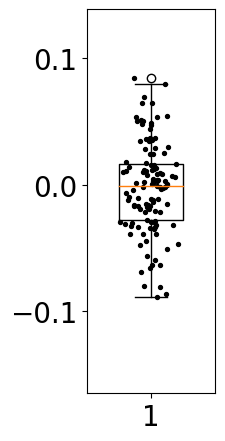

In [88]:
plt.boxplot(MFV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_rd.shape[0]))
plt.scatter(x,MFV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_powers", _xticks=False, _yticks=True, tighten=False)

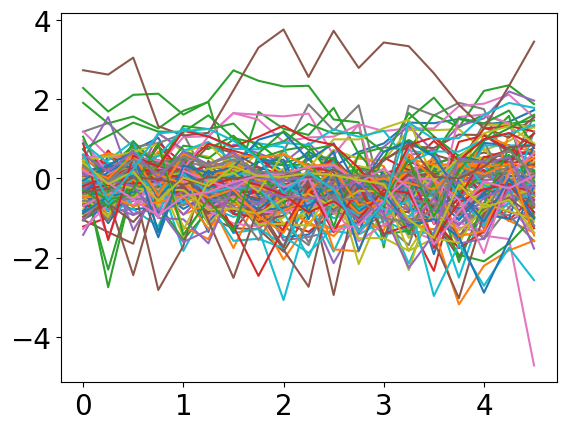

In [89]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_time", _xticks=True, _yticks=True, tighten=False)

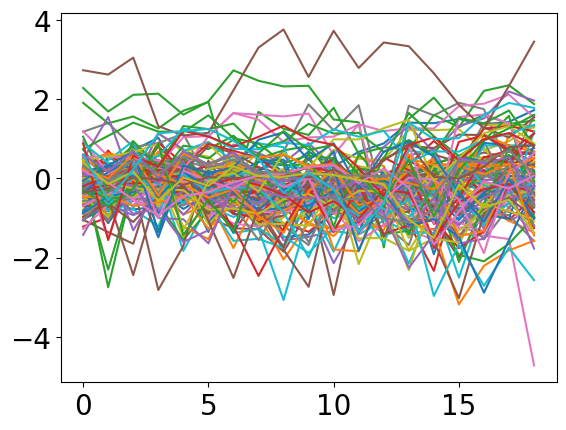

In [90]:
plt.plot(MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV", _xticks=True, _yticks=True, tighten=False)

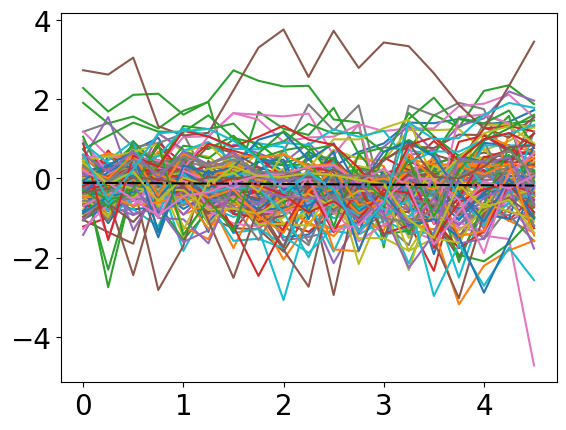

In [91]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

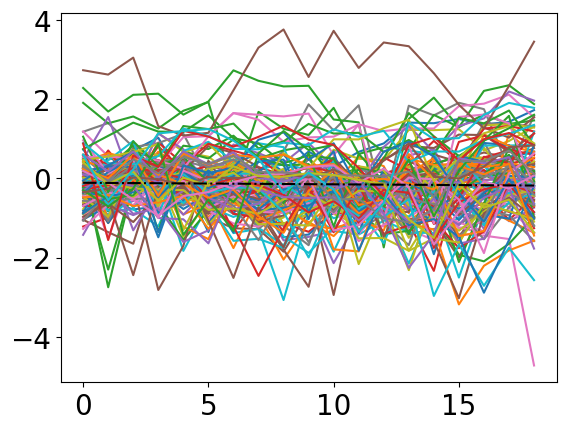

In [92]:
plt.plot(MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

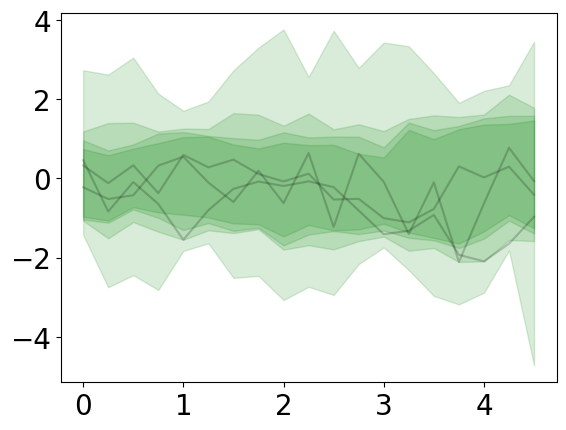

In [93]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_time", _xticks=True, _yticks=True, tighten=False)

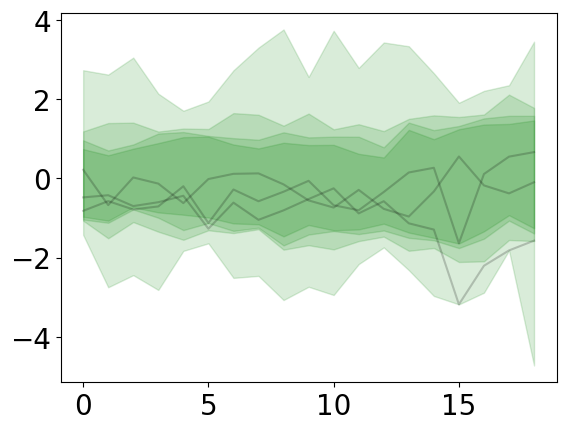

In [94]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density", _xticks=True, _yticks=True, tighten=False)

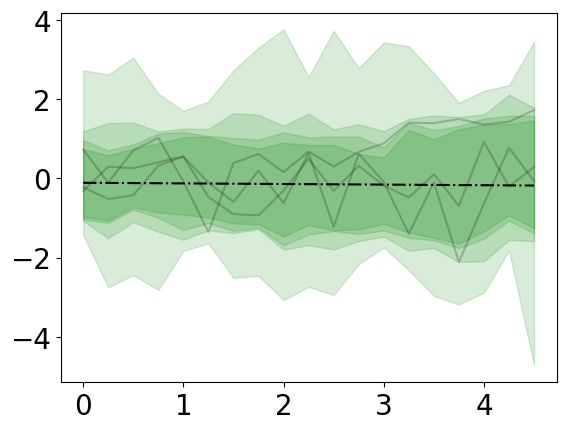

In [95]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

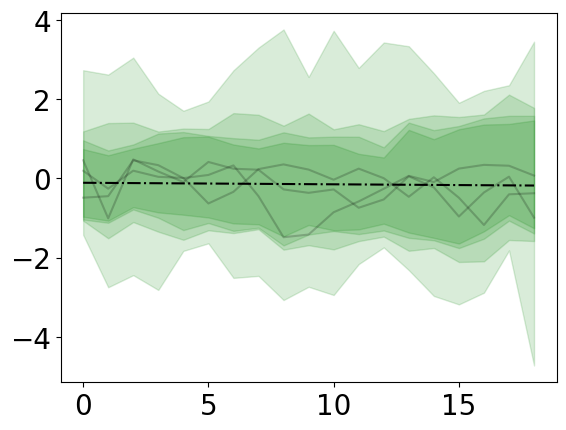

In [96]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed", _xticks=True, _yticks=True, tighten=False)

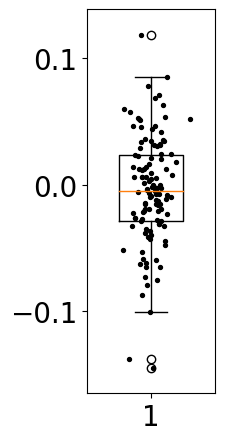

In [97]:
plt.boxplot(MLV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_rd.shape[0]))
plt.scatter(x,MLV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_powers", _xticks=False, _yticks=True, tighten=False)

### MSDs

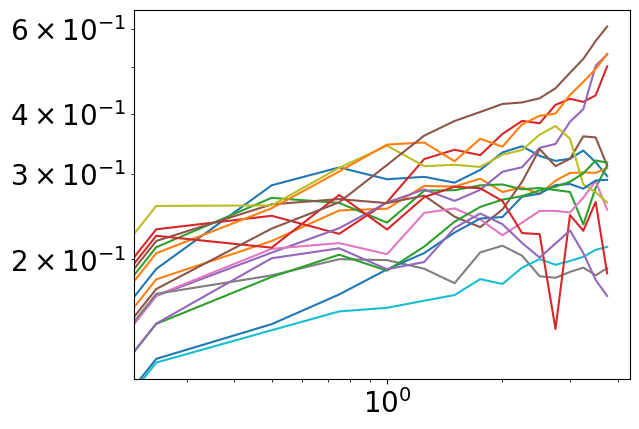

In [98]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_time", _xticks=True, _yticks=True, tighten=False)

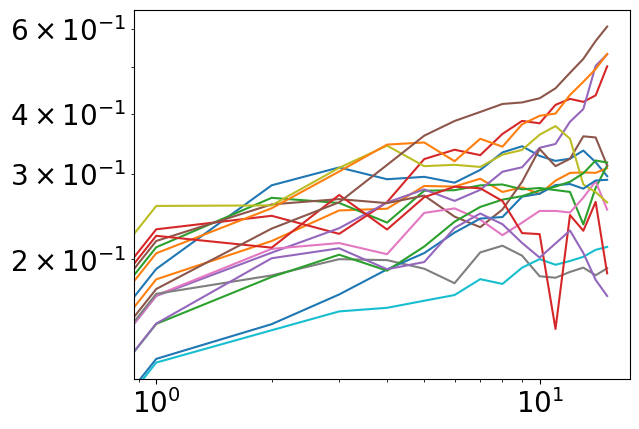

In [99]:
plt.loglog(MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV", _xticks=True, _yticks=True, tighten=False)

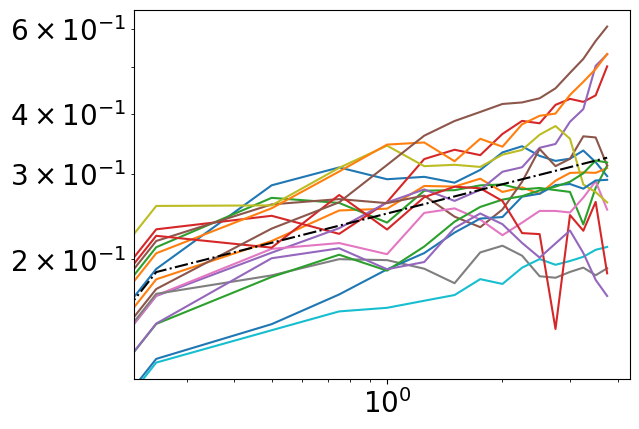

In [100]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

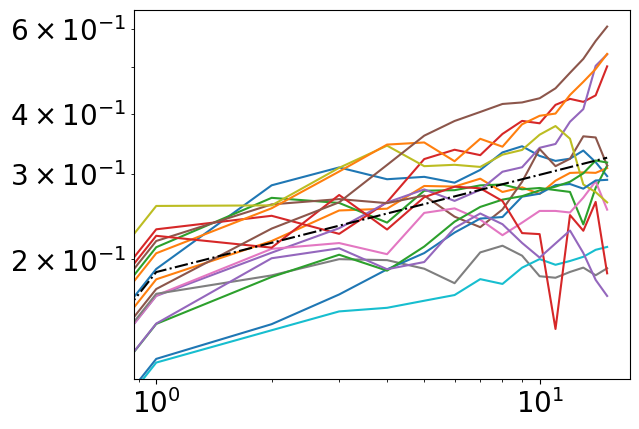

In [101]:
plt.loglog(MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MFV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

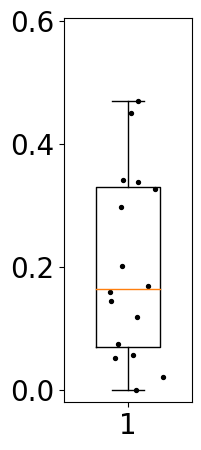

In [102]:
plt.boxplot(MFV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_msd.shape[0]))
plt.scatter(x,MFV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_powers", _xticks=False, _yticks=True, tighten=False)

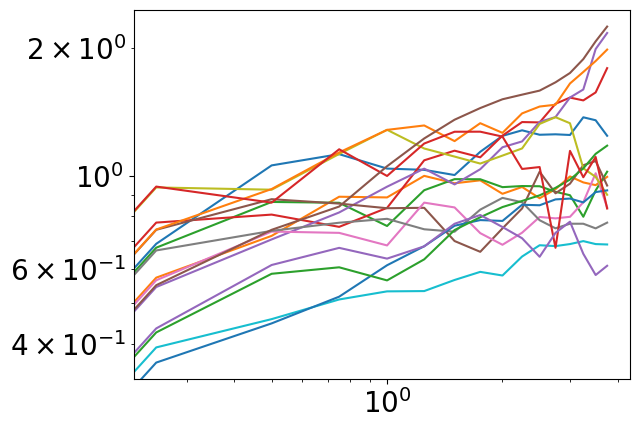

In [103]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_time", _xticks=True, _yticks=True, tighten=False)

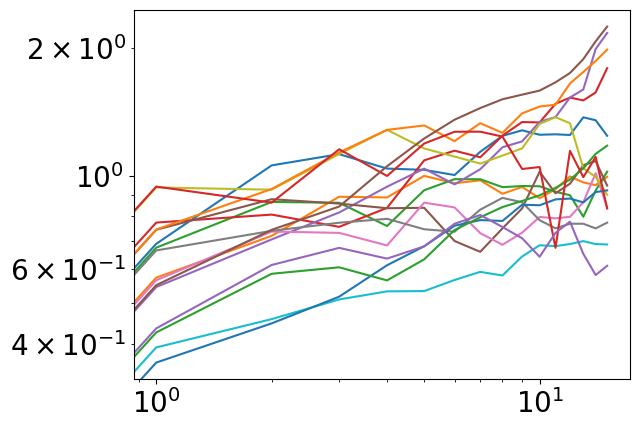

In [104]:
plt.loglog(MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV", _xticks=True, _yticks=True, tighten=False)

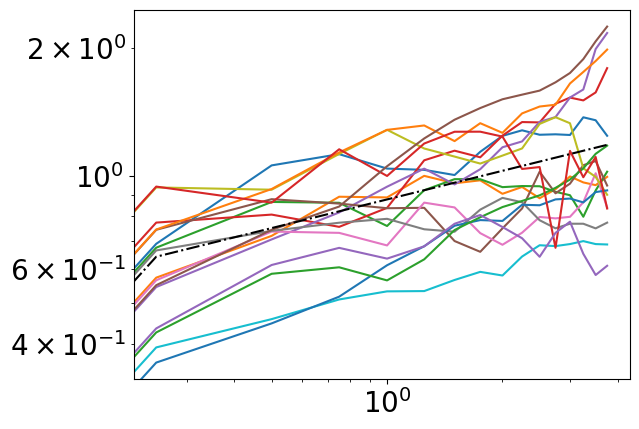

In [105]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

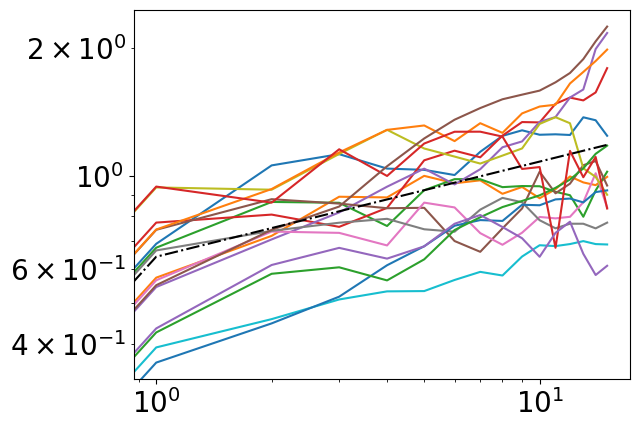

In [106]:
plt.loglog(MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MLV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

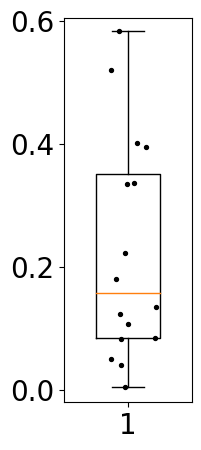

In [107]:
plt.boxplot(MLV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_msd.shape[0]))
plt.scatter(x,MLV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_powers", _xticks=False, _yticks=True, tighten=False)

### Autocorrelation

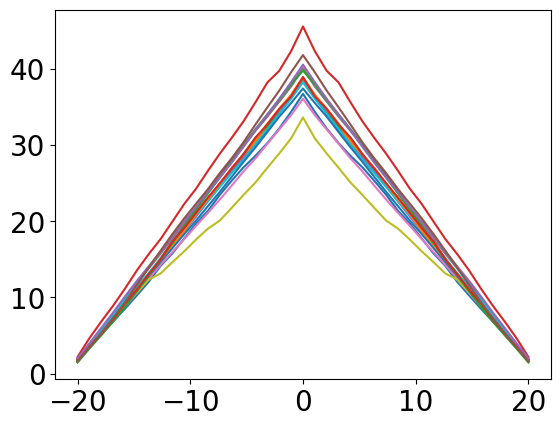

In [108]:
plot_autocorrelation(MFV_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MFV")

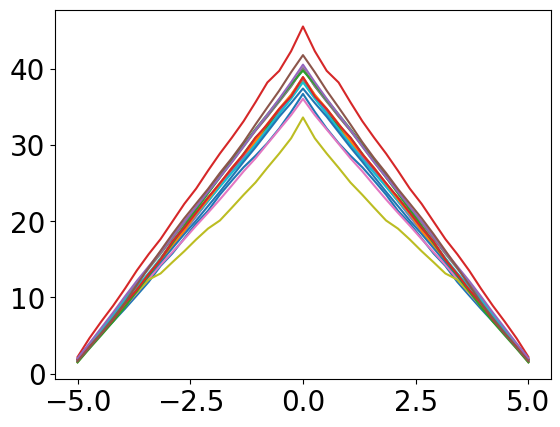

In [109]:
plot_autocorrelation(MFV_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MFV_time")

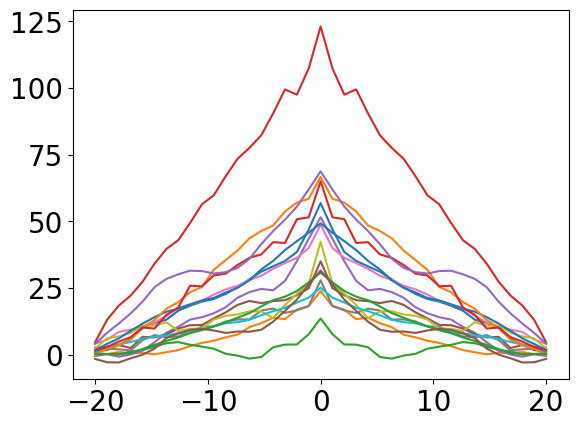

In [110]:
plot_autocorrelation(MLV_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MLV")

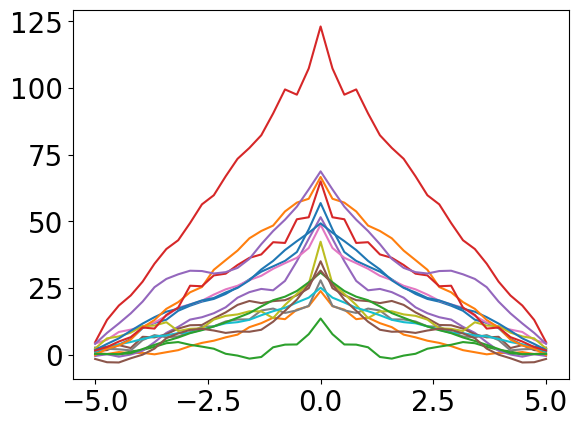

In [111]:
plot_autocorrelation(MLV_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/MLV_time")

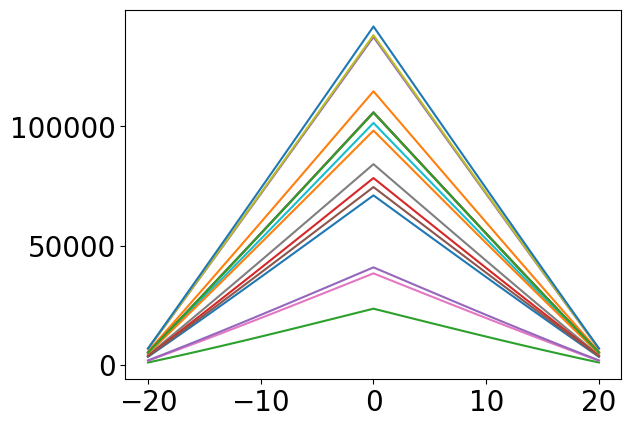

In [112]:
plot_autocorrelation(TISSUE_correlation)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/Tissue")

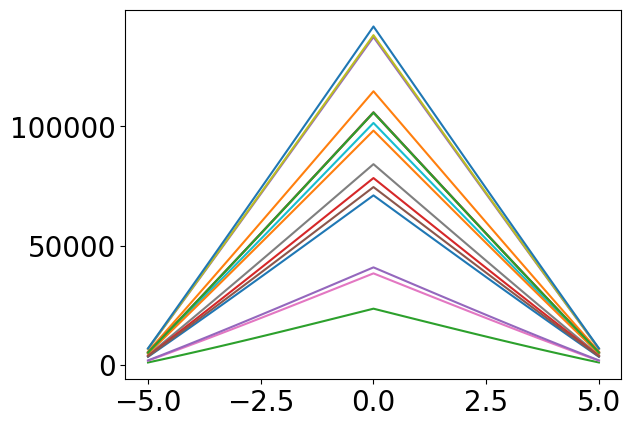

In [113]:
plot_autocorrelation(TISSUE_correlation, resolution=0.25)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/Tissue_time")

### Normalized Persistence

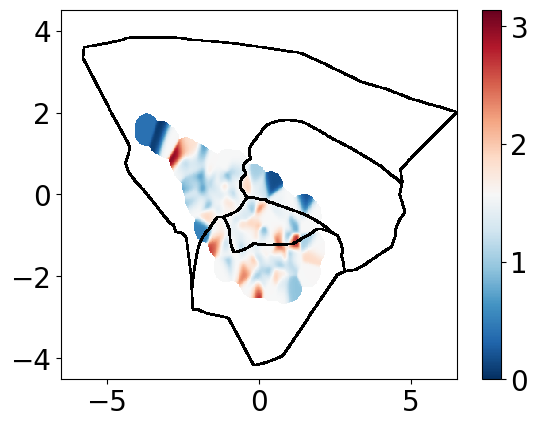

In [158]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], np.arccos(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N), cmap='RdBu_r', vmin=0, vmax=np.pi)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceAngle_BlueRed")

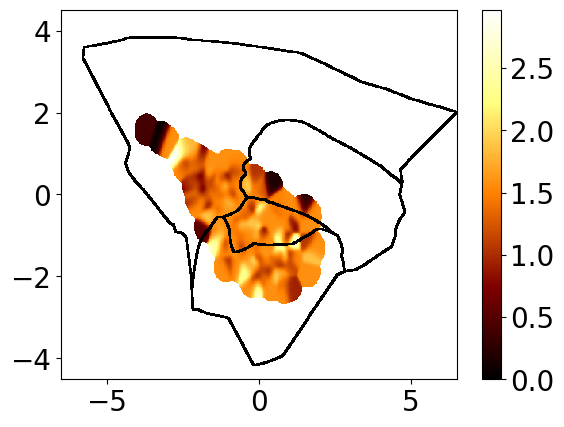

In [159]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], np.arccos(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N), cmap='afmhot', vmin=0)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceAngle")

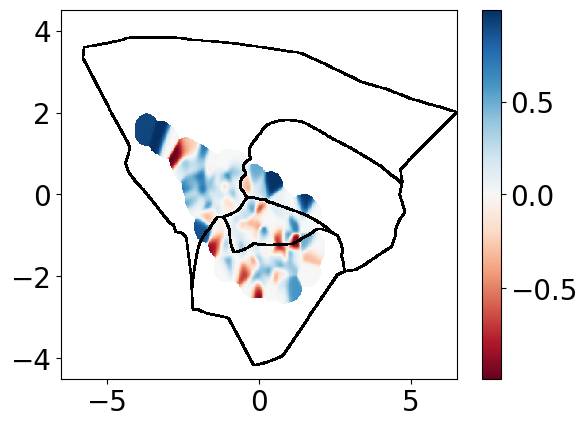

In [160]:
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N, cmap='RdBu', norm=_divnorm_x(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistence")

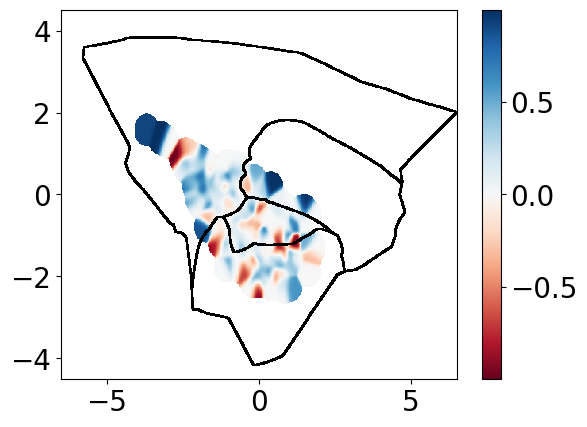

In [161]:
TISSUE_NORMALIZED_PERSISTENCE_MAX = np.max(np.abs(TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N))
plt.pcolor(TISSUE_NORMALIZED_PERSISTENCE_XY[...,0],TISSUE_NORMALIZED_PERSISTENCE_XY[...,1], TISSUE_NORMALIZED_PERSISTENCE_MASK/TISSUE_NORMALIZED_PERSISTENCE_N, cmap='RdBu', norm=_divnorm(-TISSUE_NORMALIZED_PERSISTENCE_MAX,TISSUE_NORMALIZED_PERSISTENCE_MAX))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "NormalizedPersistenceSymmetricLimits")

### Persistence

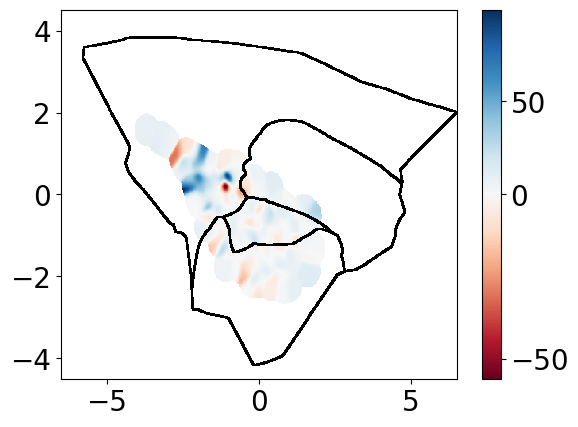

In [118]:
plt.pcolor(TISSUE_PERSISTENCE_XY[...,0],TISSUE_PERSISTENCE_XY[...,1], TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N, cmap='RdBu', norm=_divnorm_x(TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Persistence")

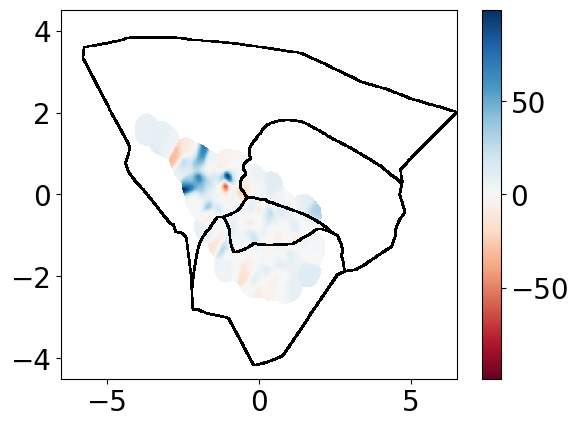

In [119]:
TISSUE_PERSISTENCE_MAX = np.max(np.abs(TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N))
plt.pcolor(TISSUE_PERSISTENCE_XY[...,0],TISSUE_PERSISTENCE_XY[...,1], TISSUE_PERSISTENCE_MASK/TISSUE_PERSISTENCE_N, cmap='RdBu', norm=_divnorm(-TISSUE_PERSISTENCE_MAX,TISSUE_PERSISTENCE_MAX))
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceSymmetricLimits")

### Motility

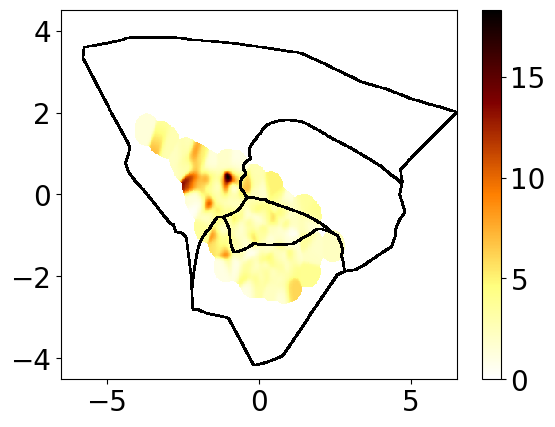

In [120]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_TOTAL/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedTotal")

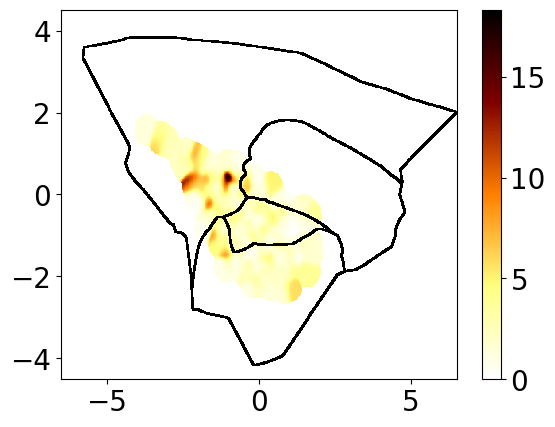

In [121]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_RAD/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedRadial")

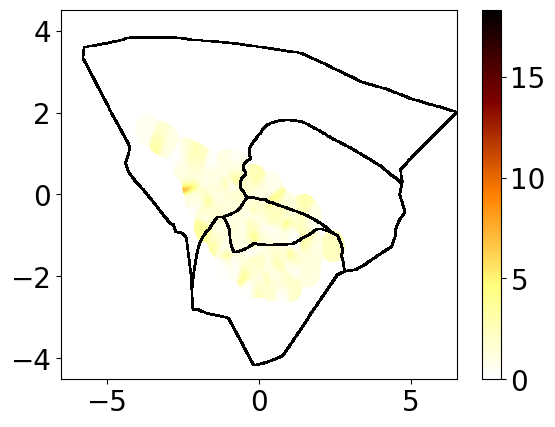

In [122]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_TANG/TISSUE_MOTILITY_MASK, cmap='afmhot_r', vmin=0, vmax=TISSUE_MOTILITY_MAX)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Motility/NormalizedTangential")

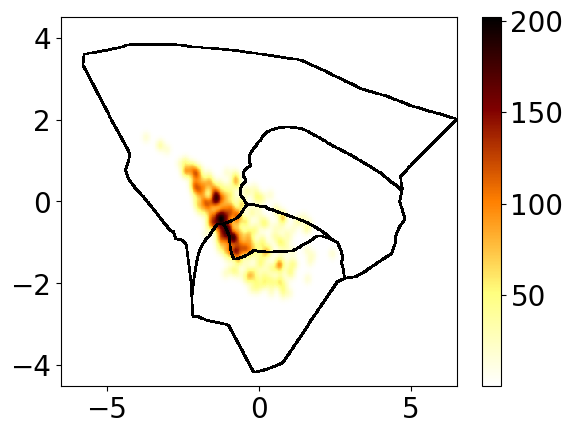

In [123]:
plt.pcolor(TISSUE_MOTILITY_XY[...,0],TISSUE_MOTILITY_XY[...,1], TISSUE_MOTILITY_MASK, cmap='afmhot_r')
plt.colorbar()
plt.apply_boundary()

### Motility + Persistence

In [314]:
import seaborn as sns
from scipy.stats import linregress
import pandas as pd

In [315]:
m_df = pd.DataFrame(MotilityData, columns=["MLA-0","MLA-1", "Total_Motility", "Radial_Motility", "Tangential_Motility"])
p_df = pd.DataFrame(NormalizedPersistenceData, columns=["MLA-0", "MLA-1", "Tissue_Persistence"])
display(m_df.head())
p_df.head()

MLA-0     MLA-1  Total_Motility  Radial_Motility  Tangential_Motility
0 -0.671156 -1.383089        3.162278         2.293575             2.177042
1 -0.943926 -0.594500        5.099020         4.966137             1.156498
2 -1.184902 -0.265609        5.000000         4.539797             2.095291
3 -0.821504 -0.869285        3.000000         1.227168             2.737528
4  0.420395 -2.215417        2.236068         1.440819             1.709983

MLA-0     MLA-1  Tissue_Persistence
0 -0.671156 -1.383089           -0.868243
1 -0.943926 -0.594500            0.000000
2 -1.184902 -0.265609            0.000000
3 -0.821504 -0.869285            0.000000
4  0.420395 -2.215417            0.000000

In [316]:
joint_df = m_df.copy().merge(p_df.copy(), how='outer', left_on=["MLA-0","MLA-1"], right_on=["MLA-0","MLA-1"]).dropna()
joint_df.shape

(399, 6)

In [317]:
joint_df['Tissue_Persistence_Theta'] = np.arccos(np.clip(joint_df['Tissue_Persistence'], -1, 1))

In [318]:
linregress(joint_df['Radial_Motility'], joint_df['Tissue_Persistence_Theta'])

LinregressResult(slope=-0.04311120148026734, intercept=1.5543800397491727, rvalue=-0.2206242705237776, pvalue=8.664598617543051e-06, stderr=0.009565463647583216, intercept_stderr=0.045860826656675645)

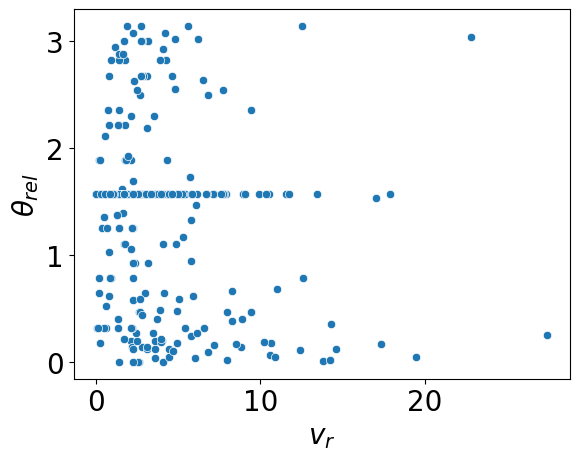

In [319]:
sns.scatterplot(joint_df, x='Radial_Motility', y='Tissue_Persistence_Theta')
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\theta_{rel}$")
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceAngleVsRadialMotility")
_ = _

In [320]:
linregress(joint_df['Radial_Motility'], joint_df['Tissue_Persistence'])

LinregressResult(slope=0.030792876325638208, intercept=0.014055761574683717, rvalue=0.21363846268124434, pvalue=1.6787405357946327e-05, stderr=0.007066939242702682, intercept_stderr=0.0338818574345564)

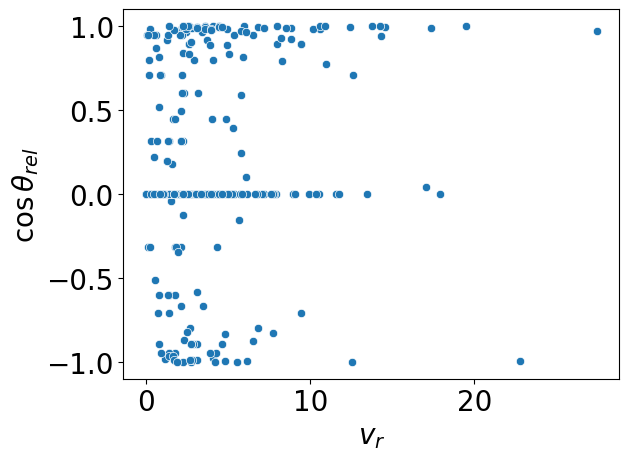

In [321]:
sns.scatterplot(joint_df, x='Radial_Motility', y='Tissue_Persistence')
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility")
_ = _

In [322]:
cov_df = df_sample.copy().merge(joint_df.copy(), how='inner', left_on=["MLA-0","MLA-1"], right_on=["MLA-0","MLA-1"])

In [323]:
from sunlab.svm import *

In [324]:
pixel2dist = 1.075268

svm_scaler, svm_clf = svm_load("../other/svm/SVM_scaler.onnx", "../other/svm/SVM_clf.onnx")

classification = svm_infer(cov_df[reduced_dataset.data_columns].to_numpy(), pixel2dist=pixel2dist, scaler_model=svm_scaler, clf_model=svm_clf)

In [325]:
np.argmax(classification, axis=-1).shape

(314,)

In [326]:
cov_df['Class'] = np.argmax(classification, axis=-1)
cov_df['Tissue_Persistence'] += (np.random.rand(*cov_df['Tissue_Persistence'].shape)-0.5)*1e-2
cov_df['Tissue_Persistence'] = np.clip(cov_df['Tissue_Persistence'], -1, 1)
cov_df['Tissue_Persistence_Theta'] = np.arccos(np.clip(cov_df['Tissue_Persistence'], -1, 1))

In [327]:
cov_df.head()

Area  MjrAxisLength  MnrAxisLength  Eccentricity  ConvexArea  \
0  157.0      23.111674      10.485540      0.891159       199.0   
1  169.0      27.180364      11.440247      0.907107       253.0   
2  166.0      32.142691       9.876421      0.951623       255.0   
3  178.0      24.591893      11.348810      0.887148       243.0   
4  112.0      13.946479      10.767801      0.635525       121.0   

   EquivDiameter  Solidity    Extent  Perimeter  ConvexPerim  ...  CellN  \
0      14.138550  0.788945  0.594697     56.940       52.598  ...   10.0   
1      14.668929  0.667984  0.391204     69.023       63.226  ...   10.0   
2      14.538149  0.650980  0.354701     79.121       76.466  ...   10.0   
3      15.054456  0.732510  0.436275     64.218       58.578  ...   10.0   
4      11.941643  0.925620  0.662722     37.836       37.555  ...   10.0   

   Frame     MLA-0     MLA-1  Total_Motility  Radial_Motility  \
0   49.0 -0.671156 -1.383089        3.162278         2.293575   
1   50.0 -0.943926 -0.594500        5.099020         4.966137   
2   51.0 -1.184902 -0.265609        5.000000         4.539797   
3   52.0 -0.821504 -0.869285        3.000000         1.227168   
4   53.0  0.420395 -2.215417        2.236068         1.440819   

   Tangential_Motility  Tissue_Persistence  Tissue_Persistence_Theta  Class  
0             2.177042           -0.864001                  2.613960      0  
1             1.156498            0.000396                  1.570401      0  
2             2.095291            0.001566                  1.569230      1  
3             2.737528            0.001656                  1.569140      0  
4             1.709983           -0.004286                  1.575082      2  

[5 rows x 25 columns]

In [328]:
cov_df.shape

(314, 25)

In [329]:
cov_df.columns

Index(['Area', 'MjrAxisLength', 'MnrAxisLength', 'Eccentricity', 'ConvexArea',
       'EquivDiameter', 'Solidity', 'Extent', 'Perimeter', 'ConvexPerim',
       'FibLen', 'InscribeR', 'BlebLen', 'X', 'Y', 'CellN', 'Frame', 'MLA-0',
       'MLA-1', 'Total_Motility', 'Radial_Motility', 'Tangential_Motility',
       'Tissue_Persistence', 'Tissue_Persistence_Theta', 'Class'],
      dtype='object')

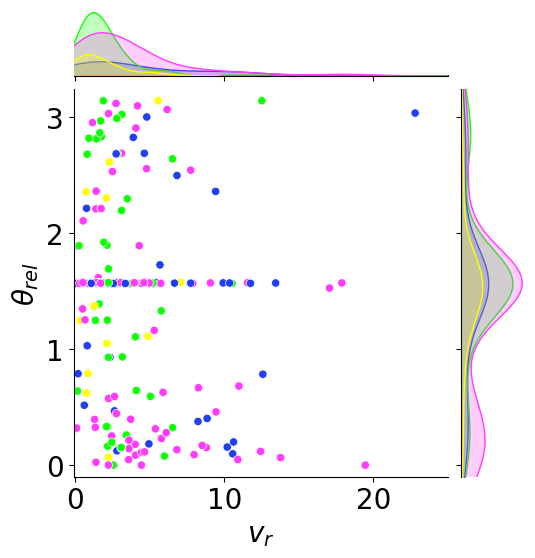

In [330]:
sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence_Theta', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\theta_{rel}$")
plt.xlim([-0.1, 25])
plt.ylim([-0.1, np.pi+0.1])
plt.gca().get_legend().remove()
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceAngleVsRadialMotility_Colored")
_ = _

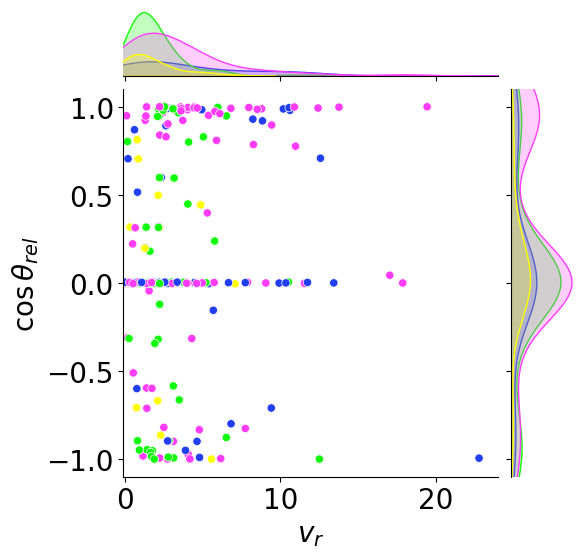

In [331]:
sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
plt.xlim([-0.1, 24])
plt.ylim([-1.1,1.1])
plt.gca().get_legend().remove()
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored")
_ = _

1.755743051880926 0.05604335763198211
3.6722577375944527 0.17332403068977828
1.990452855126257 0.005065073410843229
4.3609852817237895 0.07707058299365895


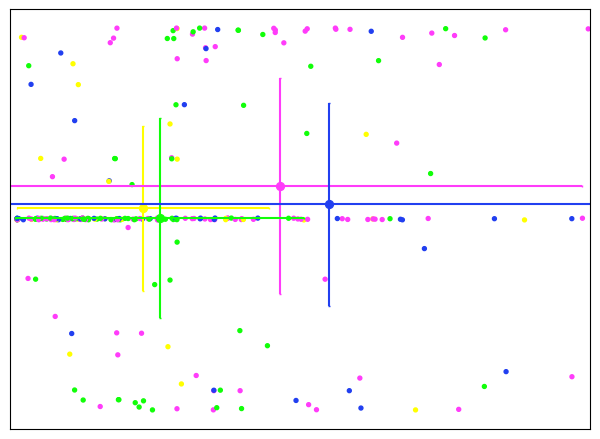

In [384]:
plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap, s=8)
for cl in range(4):
    scov_df = cov_df[cov_df['Class'] == cl].copy()
    xy_data = scov_df[['Radial_Motility','Tissue_Persistence']]
    xy_p = xy_data.mean()
    xy_e = xy_data.std()
    print(xy_p[0],xy_p[1])
    plt.scatter([xy_p[0]],[xy_p[1]], c=Pcolor[cl], s=32)
    plt.errorbar([xy_p[0]],[xy_p[1]], xerr=xy_e[0], yerr=xy_e[1], capsize=1, c=Pcolor[cl])
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
plt.xlim([-0.1, 8])
plt.ylim([-1.1,1.1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_C_large_dot")
_ = _

1.755743051880926 0.05604335763198211
3.6722577375944527 0.17332403068977828
1.990452855126257 0.005065073410843229
4.3609852817237895 0.07707058299365895


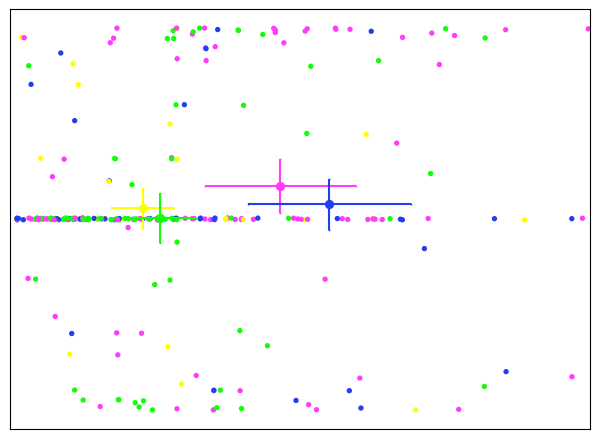

In [387]:
plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap, s=8)
for cl in range(4):
    scov_df = cov_df[cov_df['Class'] == cl].copy()
    xy_data = scov_df[['Radial_Motility','Tissue_Persistence']]
    xy_p = xy_data.mean()
    xy_e = xy_data.std()
    print(xy_p[0],xy_p[1])
    plt.scatter([xy_p[0]],[xy_p[1]], c=Pcolor[cl], s=32)
    plt.errorbar([xy_p[0]],[xy_p[1]], xerr=xy_e[0]/4, yerr=xy_e[1]/4, capsize=1, c=Pcolor[cl])
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
plt.xlim([-0.1, 8])
plt.ylim([-1.1,1.1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_C_large_dot_quarter_std")
_ = _

1.755743051880926 0.05604335763198211
3.6722577375944527 0.17332403068977828
1.990452855126257 0.005065073410843229
4.3609852817237895 0.07707058299365895


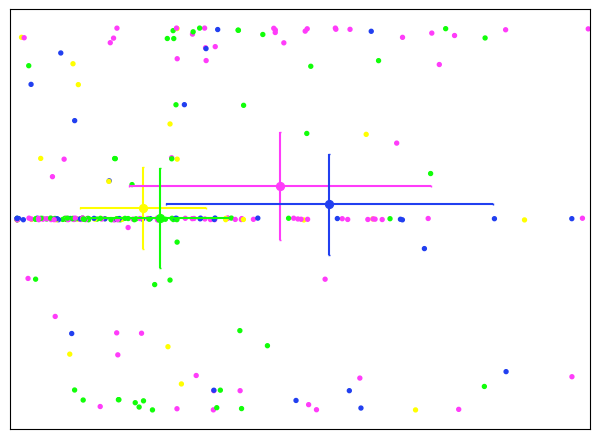

In [385]:
plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap, s=8)
for cl in range(4):
    scov_df = cov_df[cov_df['Class'] == cl].copy()
    xy_data = scov_df[['Radial_Motility','Tissue_Persistence']]
    xy_p = xy_data.mean()
    xy_e = xy_data.std()
    print(xy_p[0],xy_p[1])
    plt.scatter([xy_p[0]],[xy_p[1]], c=Pcolor[cl], s=32)
    plt.errorbar([xy_p[0]],[xy_p[1]], xerr=xy_e[0]/2, yerr=xy_e[1]/2, capsize=1, c=Pcolor[cl])
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
plt.xlim([-0.1, 8])
plt.ylim([-1.1,1.1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_C_large_dot_half_std")
_ = _

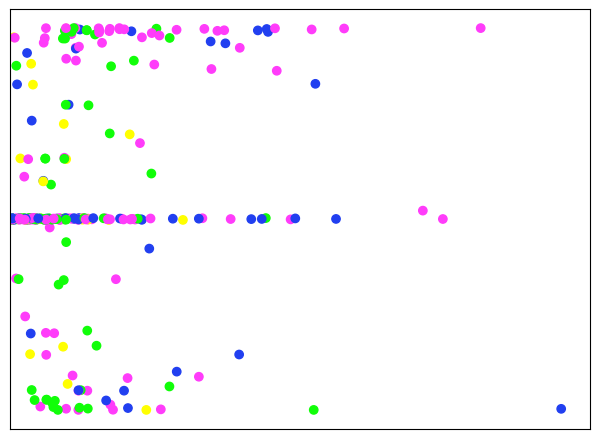

In [357]:
plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap)
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
plt.ylabel(r"$\cos\theta_{rel}$")
plt.xlim([-0.1, 24])
plt.ylim([-1.1,1.s1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_C")
_ = _

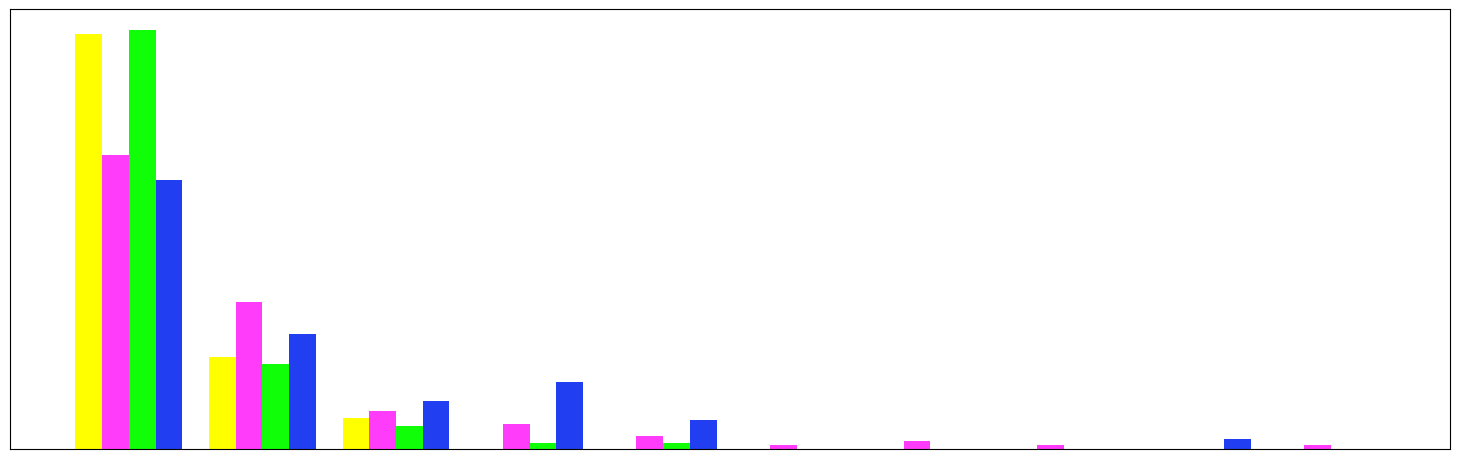

In [358]:
plt.figure(figsize=(15,5))
plt.hist([cov_df[cov_df['Class'] == CAT]['Radial_Motility'] for CAT in range(4)], color=Pcolor, density=True)
#plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap)
#plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap)
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$v_r$")
# plt.xlim([-0.1, 24])
# plt.ylim([-1.1,1.1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_D1")
_ = _

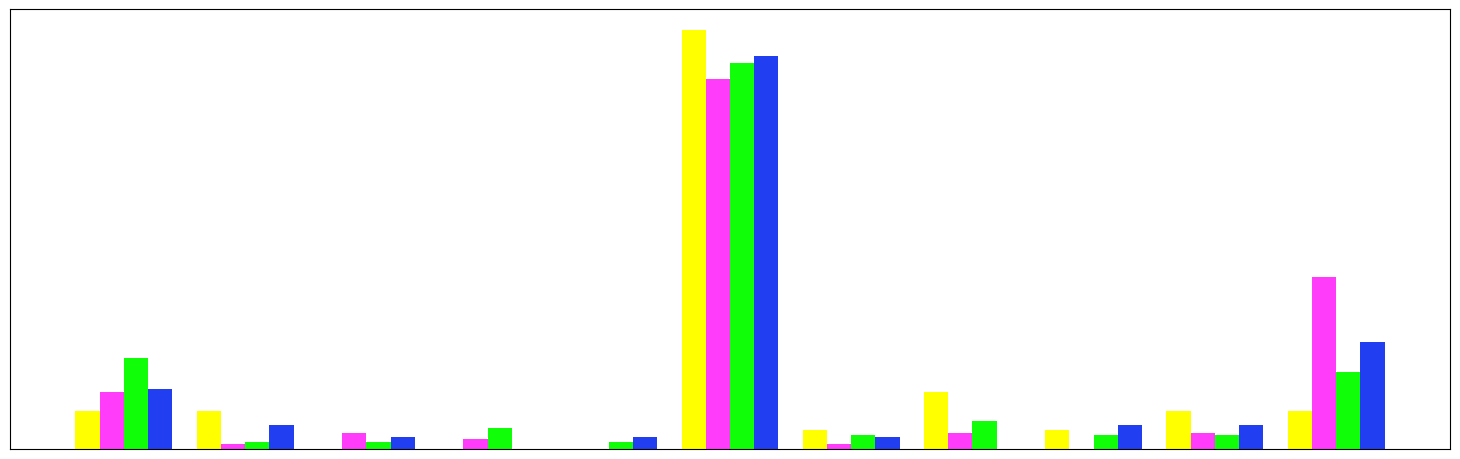

In [363]:
plt.figure(figsize=(15,5))
plt.hist([cov_df[cov_df['Class'] == CAT]['Tissue_Persistence'] for CAT in range(4)], bins=11, color=Pcolor, density=True)
#plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap)
#plt.scatter(cov_df['Radial_Motility'],cov_df['Tissue_Persistence'], c=cov_df['Class'].to_numpy(), cmap=Pmap)
# sns.jointplot(cov_df, x='Radial_Motility', y='Tissue_Persistence', hue='Class', palette=Pmap)
plt.xlabel(r"$\cos\theta_{rel}$")
# plt.xlim([-0.1, 24])
# plt.ylim([-1.1,1.1])
if SAVE_EXTRAS:
    plt.save(g_Base() + "PersistenceVsRadialMotility_Colored_D2")
_ = _

# END